In [1]:
import numpy as np, pandas as pd
import json, pickle
import matplotlib.pyplot as plt

#import py modules:
import PES_data_processor as pdata, PES_models as pmodel

## ansatz vs CHIPR on OH$^+$ data

In [2]:
list_data = np.load('data/hxoy_data.npy', allow_pickle=True) #reload
list_data = list_data[()]

In [3]:
mol = "OH+"
qidxes = pdata.query_one_var_indices(mol, "mol", list_data)

In [42]:
#display the table result:


'''
data = pd.read_pickle("result/performance_22102021.pkl")
display = data[['num_params', 'ansatz_acc', 'chipr_acc','ansatz_t', 'chipr_t', ]]
display
'''
fname0 = "result/performance_22102021.pkl"
#fname = "result/performance_03112021.pkl" #only acc eval
fname = "result/cross_val_performance_OH+_11112021.pkl" #contains time eval
with open(fname0, 'rb') as handle:
    data0 = pickle.load(handle)
with open(fname, 'rb') as handle:
    data = pickle.load(handle)
data["ansatz_0_t"] = data0["ansatz_t"]; data["chipr_t"] = data0["chipr_t"]; data["eval_loop"]=data0["eval_loop"]; data["eval_run"]=data0["eval_run"] #join time eval
filter = ['num_params', 'ansatz_0_acc_test', 'chipr_acc_test', "ansatz_0_t", "chipr_t"] #joined data filter
display = {k:data[k] for k in filter if k in data} #key filter
display = pd.DataFrame(display) #filter the data
display

,num_params,ansatz_0_acc_test,chipr_acc_test,ansatz_0_t,chipr_t
0,13,0.000645,0.000349,0.410673,0.456578
1,22,0.000584,0.000294,0.591657,0.784567
2,31,0.000808,0.000114,0.781771,1.118280
3,40,0.000049,0.000151,0.951766,1.416891
4,49,0.000854,0.000322,1.134819,1.742435
5,58,0.000991,0.000400,1.316050,2.063720
6,67,0.000603,0.000418,1.505820,2.398215
7,76,0.001165,0.000242,1.688335,2.716334
8,85,0.000726,0.000316,1.872056,3.033693


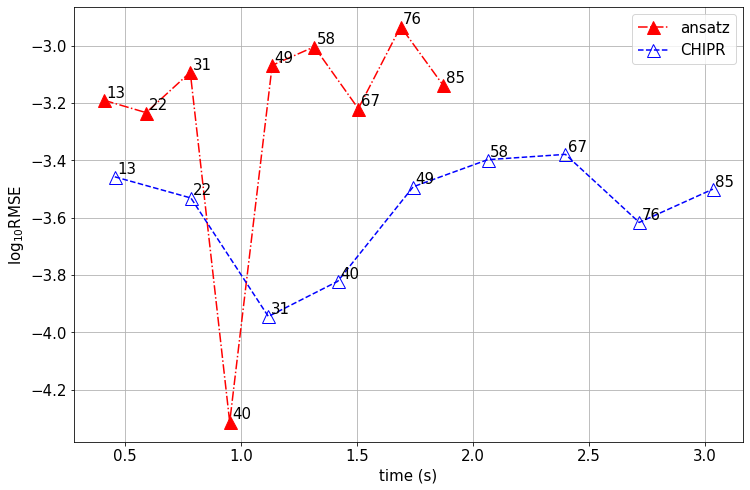

==== Optimization stats ====
optimization restarts =  10
optimization power =  3
delta threshold =  1e-05
evaluation loops =  10000
evaluation runs =  20
elapsed time =  15895.41940832138 s


In [55]:
## plot of the table (finding which model is the best)
plt.rcParams.update({'font.size': 15})
#plt.subplots(figsize=(12, 8))
fig, ax = plt.subplots(figsize=(12, 8))

markersize = 13

numparams = [str(param) for param in data["num_params"]]

x = data["ansatz_0_t"]; y = np.log10(data["ansatz_0_acc_test"])
ax.plot(x, y, '-.r^', markersize=markersize)
for i, xy in enumerate(np.array(list(zip(x, y)))):
    ax.annotate(numparams[i], xy=xy+0.01, textcoords='data')
x = data["chipr_t"]; y = np.log10(data["chipr_acc_test"])
ax.plot(x, y, '--b^', markersize=markersize, fillstyle="none")
for i, xy in enumerate(np.array(list(zip(x, y)))):
    ax.annotate(numparams[i], xy=xy+0.01, textcoords='data')


plt.xlabel("time (s)"); plt.ylabel("log$_{10}$RMSE")
plt.legend(["ansatz", "CHIPR"])

ax.grid()
plt.show()
print("==== Optimization stats ====")
#print("data: ", list_data[qidxes[0]]["mol"], list_data[qidxes[0]]["state"], list_data[qidxes[0]]["author"], len(R),"data points")
print("optimization restarts = ",data["opt_restart"])
print("optimization power = ", data["opt_power"])
print("delta threshold = ", data["opt_delta"])
print("evaluation loops = ",data["eval_loop"][0])
print("evaluation runs = ",data["eval_run"][0])
print("elapsed time = ", data["simulation_time"], "s")

## Error plots

### <li>  Joint fit OH$^+$, ansatz vs CHIPR

In [73]:
#Query the data:
mol = "OH+"
qidxes = pdata.query_one_var_indices(mol, "mol", list_data)

#join the R and V:
R_list = []; V_list = []
for i in qidxes:
    R = list_data[i]["R"]
    V = list_data[i]["V"]
    R_list.append(R); V_list.append(V)

R_list = np.array(R_list); V_list = np.array(V_list)
R = np.concatenate(R_list)
V = np.concatenate(V_list)

C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


In [56]:
'''
data = pd.read_pickle("result/res_joint_OH+_271021_153617.pkl")
data = pd.read_pickle("result/res_joint_OH+_291021_160942.pkl")
C_ans = np.array(data["ansatz_C"][0]); C_chipr = np.array(data["chipr_C"][0]); C_dn = np.array(data["dn_C"][0]); C_ds = np.array(data["ds_C"][0]) #adds [0] indexer due to pandas' length trickery
Cs = [C_ans, C_chipr, C_dn, C_ds]
'''
fname = "result/res_joint_OH+_021121_175502.pkl"
with open(fname, 'rb') as handle:
    data = pickle.load(handle)
C_ans = data["ansatz_1_C"]; C_chipr = data["chipr_C"]; 
Cs = [C_ans, C_chipr]

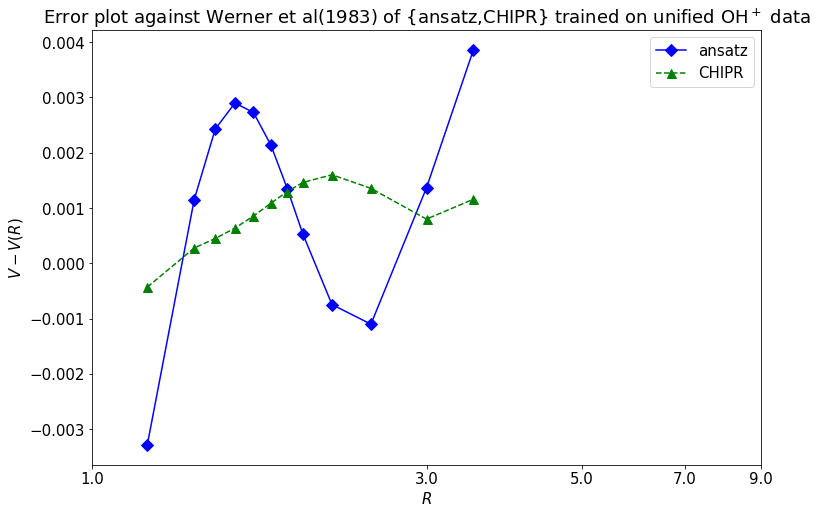

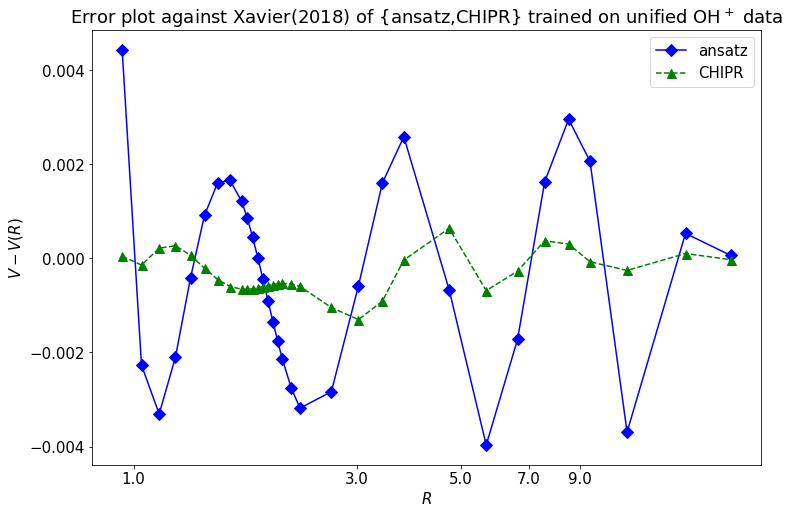

In [57]:
#plot the error on all OH+ data, error of ansatz vs CHIPR:
'''
Fs = [pmodel.f_diatomic_vdw, pmodel.f_diatomic_chipr_ohplus, pmodel.f_diatomic_dn, pmodel.f_diatomic_ds]
M = int((len(C_ans)-1)/3)
m = int((2*M - 2)/3)
'''
Fs = [pmodel.f_diatomic_ansatz_1, pmodel.f_diatomic_chipr_ohplus]
Z = 8 #for OH+
M = int(len(C_ans)/4)
m = M - 1
shapes = ["-bD","--g^", "-.rs", "-rP"]; markersize=9
for i in range(len(V_list)):
    plt.subplots(figsize=(12, 8))
    #args = [(R_list[i],Z,M), (R_list[i],Z,M,m), (R_list[i],), (R_list[i],)]
    args = [(R_list[i],Z,M), (R_list[i],Z,M,m)]
    for j in range(len(Fs)):
        f = Fs[j]
        C = Cs[j]
        V_pred = f(C, *args[j])
        err = V_pred - V_list[i]
        plt.plot(np.log10(R_list[i]), err, shapes[j], markersize=markersize)
    ticks = np.linspace(1, 9, 5) #5 ticks between 1-9 Angstrom
    plt.xticks(np.log10(ticks), ticks)
    data = list_data[qidxes[i]]
    #legends = ["ansatz", "CHIPR", "Deiters-Neumaier", "Deiters-Sadus"]
    legends = ["ansatz", "CHIPR"]
    plt.xlabel("$R$")
    plt.ylabel("$V-V(R)$")
    plt.legend(legends)
    plt.title("Error plot against "+str(list_data[qidxes[i]]["author"])+" of {ansatz,CHIPR} trained on unified OH$^+$ data" )

### <li> Joint Fit, solo functional form (only ansatz)

In [62]:
# load result:
fname = "result/res_joint_solo_OH+_021121_185141.pkl"
with open(fname, 'rb') as handle:
    data = pickle.load(handle)

#### RMSE Plot:

Text(0.5, 1.0, 'RMSE of ansatz_1 on union data of OH+')

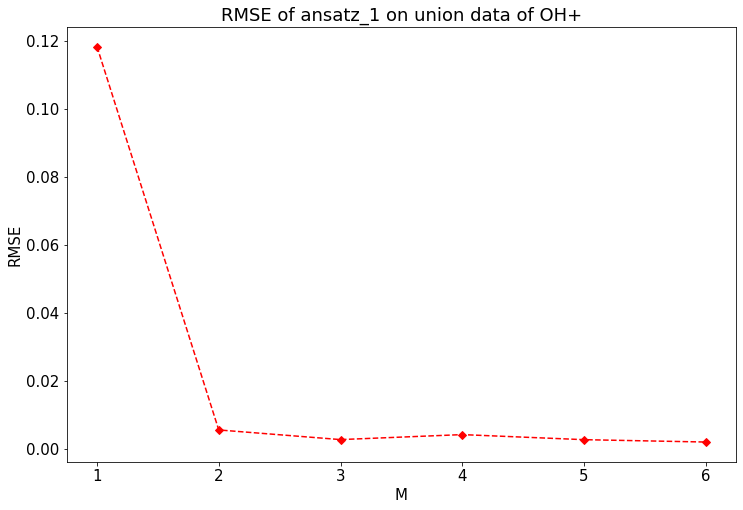

In [72]:
plt.subplots(figsize=(12, 8))
plt.plot(data["degree"], data["ansatz_1_acc"], "--rD")
plt.xlabel("M"); plt.ylabel("RMSE")
plt.title("RMSE of ansatz_1 on union data of "+mol)

#### Error plots:

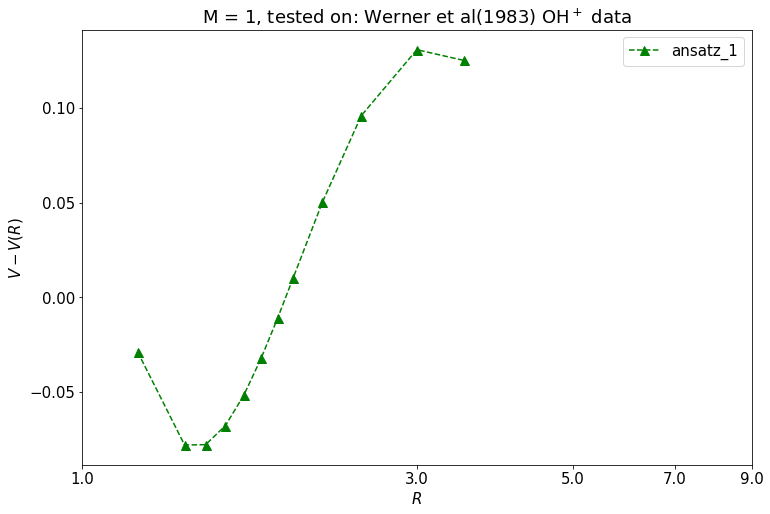

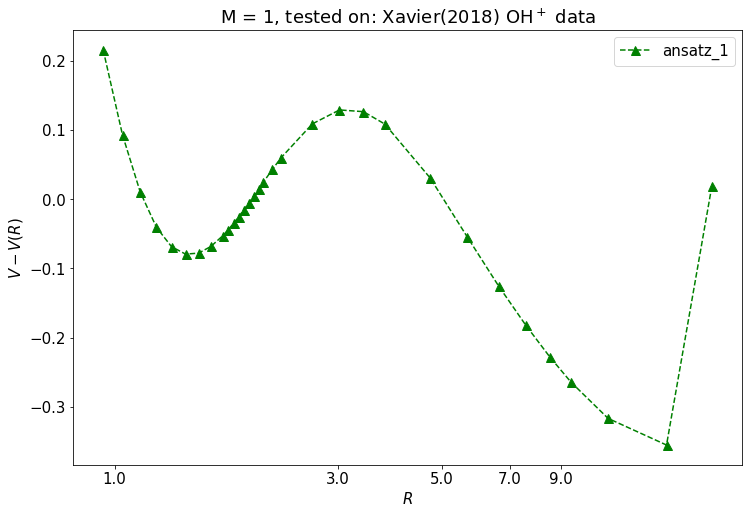

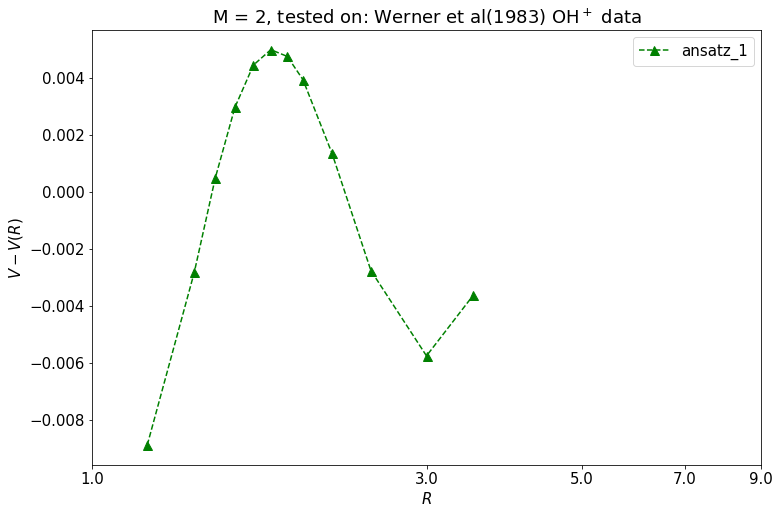

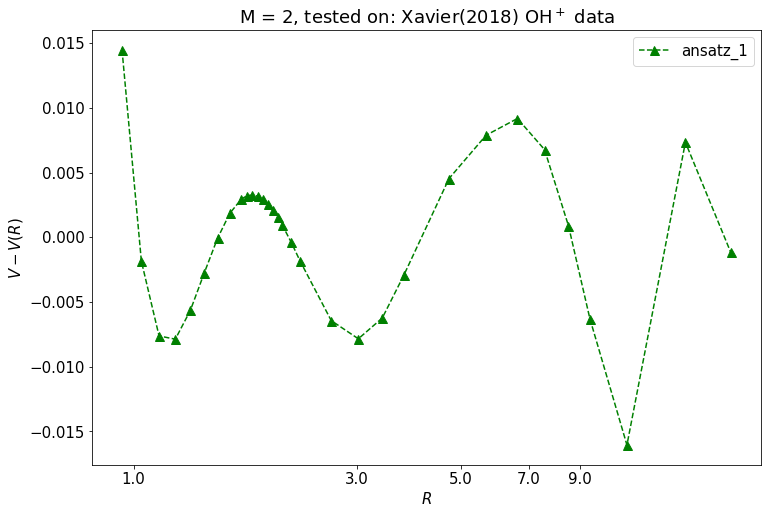

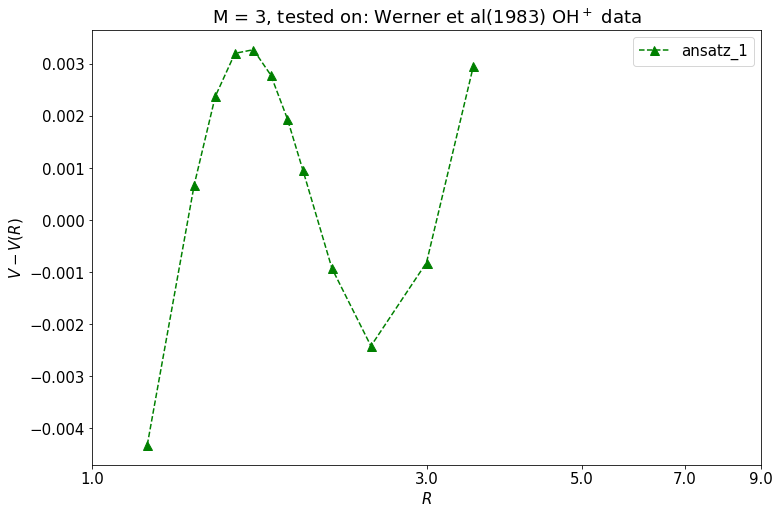

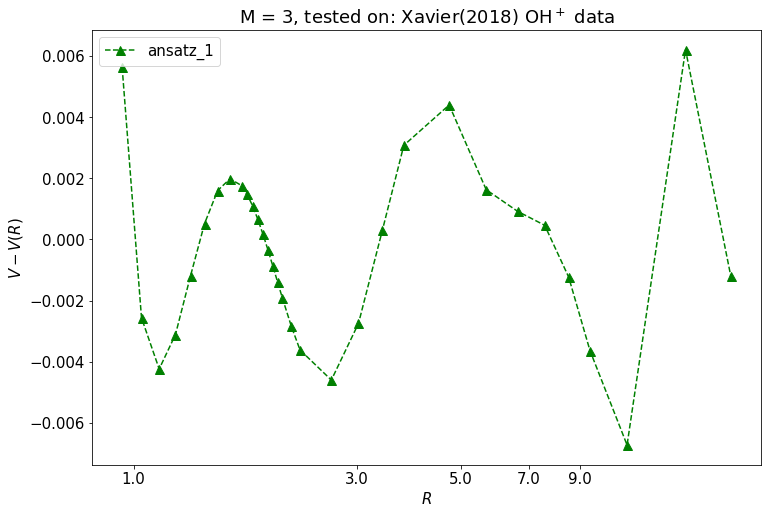

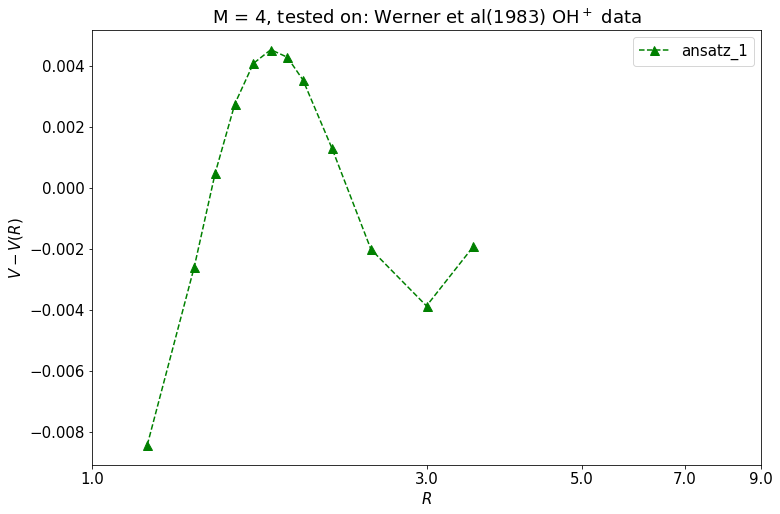

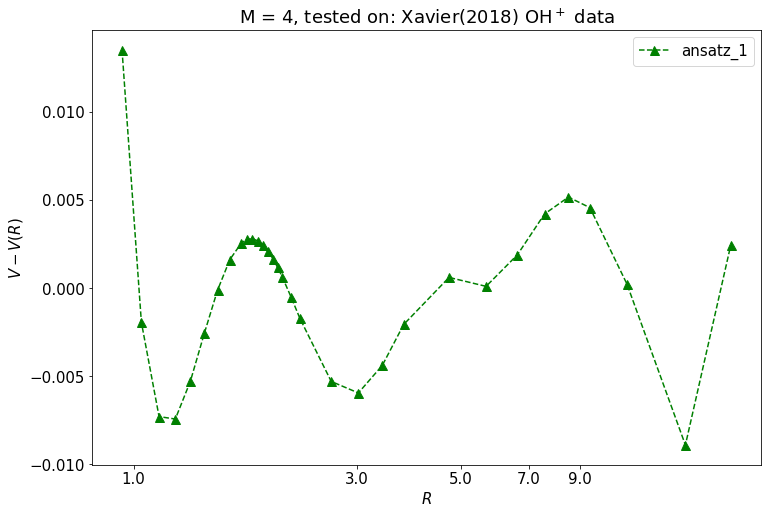

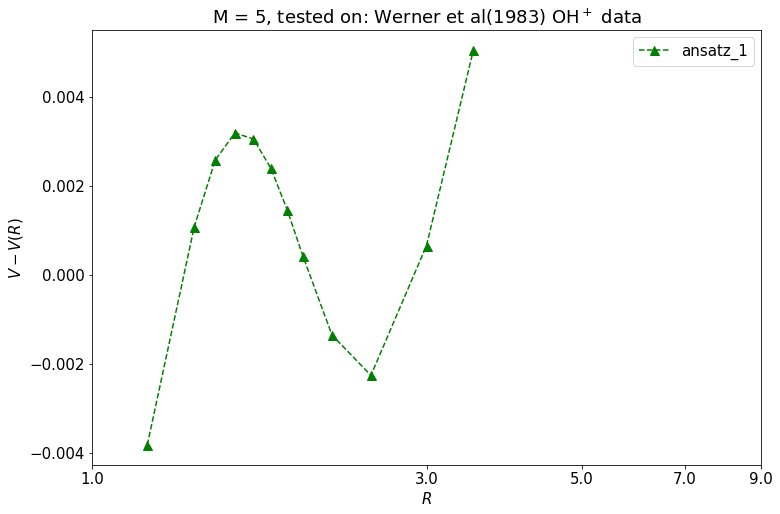

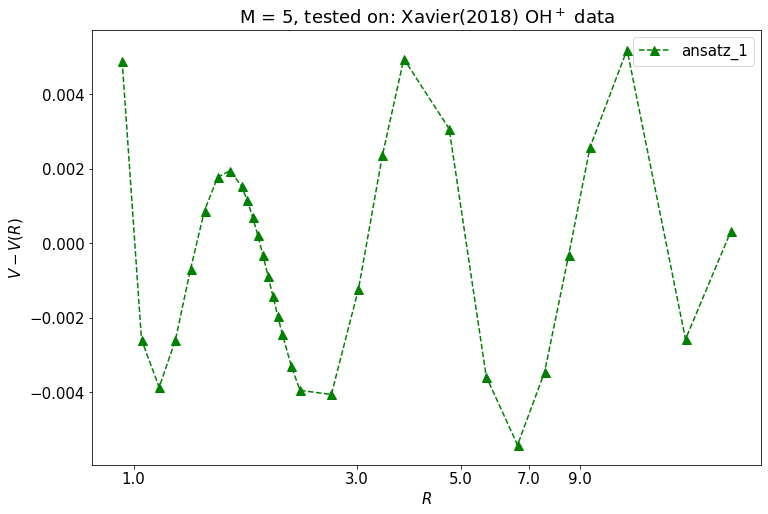

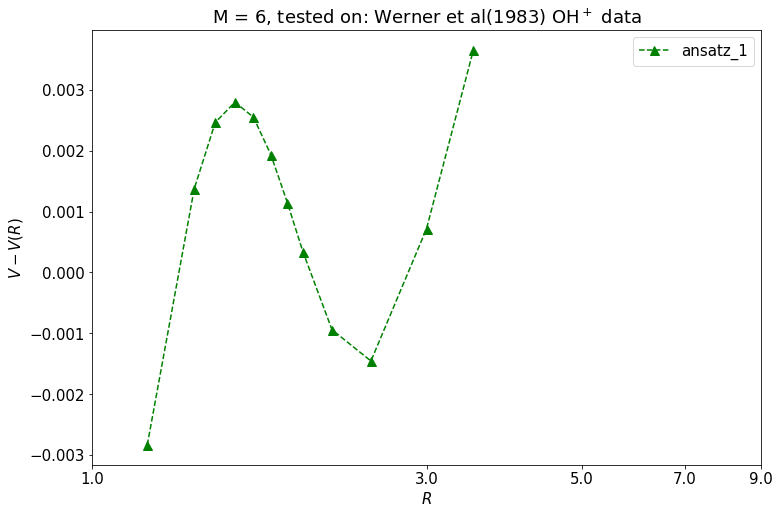

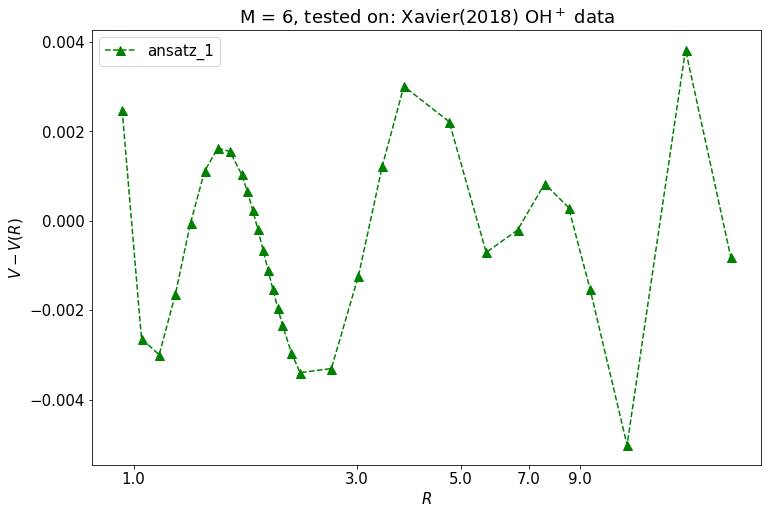

In [76]:
F = pmodel.f_diatomic_ansatz_1
Z = 8 #for OH+
shapes = ["-bD","--g^", "-.rs", "-rP"]; markersize=9
for k, M in enumerate(data["degree"]):
    for i in range(len(V_list)):
        plt.subplots(figsize=(12, 8))
        #args = [(R_list[i],Z,M), (R_list[i],Z,M,m), (R_list[i],), (R_list[i],)]
        arg = (R_list[i],Z,M)
        C = data["ansatz_1_C"][k]
        V_pred = F(C, *arg)
        err = V_pred - V_list[i]
        plt.plot(np.log10(R_list[i]), err, shapes[j], markersize=markersize)
        ticks = np.linspace(1, 9, 5) #5 ticks between 1-9 Angstrom
        plt.xticks(np.log10(ticks), ticks)
        #legends = ["ansatz", "CHIPR", "Deiters-Neumaier", "Deiters-Sadus"]
        legends = ["ansatz_1"]
        plt.xlabel("$R$")
        plt.ylabel("$V-V(R)$")
        plt.legend(legends)
        plt.title("M = "+str(M)+", tested on: "+str(list_data[qidxes[i]]["author"])+" OH$^+$ data")

### Coeff, dataset, and program example

#### R and V data:

In [61]:
print("R = ", R)
print("V = ", V)

R =  [ 1.2         1.4         1.5         1.6         1.7         1.8
  1.9         2.          2.2         2.5         3.          3.5
  0.94486299  1.03934929  1.13383559  1.22832189  1.32280819  1.41729449
  1.51178079  1.60626709  1.70075339  1.74799654  1.79523969  1.84248284
  1.88972599  1.93696914  1.98421229  2.03145544  2.07869859  2.17318489
  2.26767119  2.64561638  3.02356158  3.40150678  3.77945198  4.72431497
  5.66917797  6.61404096  7.55890395  8.50376695  9.44862994 11.33835593
 15.11780791 18.89725989]
V =  [0.59540023 0.41951623 0.37227423 0.34183223 0.32329423 0.31319223
 0.30905123 0.30909423 0.31695423 0.33773423 0.37575123 0.40821123
 1.13576423 0.87267523 0.68914423 0.56098753 0.47182183 0.41039383
 0.36884623 0.34161123 0.32470223 0.31918723 0.31524223 0.31262723
 0.31113823 0.31060023 0.31086423 0.31180123 0.31330223 0.31762823
 0.32323923 0.35120723 0.37953023 0.40429143 0.42511133 0.46398523
 0.48699363 0.4963278  0.49909276 0.49988219 0.50016526 0.500293


#### Coefficients:

In [65]:
for i, c in enumerate(data['ansatz_1_C']):
    print("========================")
    print("M = ",data["degree"][i])
    print("C = ",c)

M =  1
C =  [ 1.33832861 -0.44164341  0.59216667 -0.20030863]
M =  2
C =  [ 0.92093072  0.88447074 -1.83507446 -0.038016    1.14898977  0.11881785
 -0.01726814  0.00337724]
M =  3
C =  [-2.94048238e+00  3.82829572e+00 -7.37730353e+01 -1.59773951e+01
 -9.86050691e+00  3.85026598e+01  1.10596835e+00 -4.00253227e+02
  1.00828843e-01 -8.22854221e-03 -9.27993310e+02  3.71321910e-03]
M =  4
C =  [ 3.28646546e+00  3.37950890e-01 -1.26492773e+01  8.82972432e-01
  1.87574999e+00  1.06991292e+00  1.76360270e+01 -3.82037997e-02
 -1.00525349e-01  1.80746283e+00 -1.59696586e+01  5.14032765e-02
 -1.24961594e+00 -1.81363692e-01 -8.82940269e+00  5.77979644e-04]
M =  5
C =  [ 0.32488133  0.86160605  1.39536308  3.12209737 -1.14224706  0.77341956
  5.79291808 -0.11375624 -0.95158957 -3.34582198  1.71530495 -1.08577344
  2.93661234 -0.0593335   1.4799715  -0.23517042 -0.87552914  3.52862497
 -0.01820038 -0.21601017]
M =  6
C =  [-4.61014730e+00  4.31963666e+00 -4.11020491e+00  1.81461350e+00
  3.48253548

#### The used functions:

In [90]:
import numpy as np # only numpy is required from this cell onwards

def f_diatomic_ansatz_1(C, *args): # ansatz 0 was the f_diatomic_vdw
    R = args[0]
    Z = args[1]
    M = args[2] #degree of pol
    #coefficients:
    a = C[: M]
    b = C[M : 2*M]
    c = C[2*M : 3*M]
    d = C[3*M : 4*M]
    #physical params:
    s = Z/R; t=s**2
    q = t/(1+t)
    prod = 1
    for k in range(M):
        numer = (q - a[k])**2 + b[k]
        denom = (q - c[k])**2 + d[k]
        prod *= numer/denom
    V = (q**3)*(s - prod)
    return V

# the RMSE, used for example in below cell:
def RMSE(Y_pred, Y):
    #error between Y prediction and Y actual
    error = 0
    n = len(Y)
    for i in range(n):
        diff = (Y[i]-Y_pred[i])**2
        error += diff
    return np.sqrt(error/n)

#### How to use (example):

In [91]:
Z = 8
C = np.array([-2.94048238e+00,  3.82829572e+00, -7.37730353e+01, -1.59773951e+01,
 -9.86050691e+00,  3.85026598e+01,  1.10596835e+00, -4.00253227e+02,
  1.00828843e-01, -8.22854221e-03, -9.27993310e+02,  3.71321910e-03])
M = 3 # or int(len(C)/4)
V_pred = f_diatomic_ansatz_1(C, R, Z, M)
print("RMSE = ",RMSE(V_pred, V))

RMSE =  0.0027992983408858378


### <li> Separate fit

In [ ]:
data = pd.read_pickle("result/res_each_state_271021_145320.pkl")
# OH+:
mol = "OH+"
Z = 8 #for OH+
M = int((data["num_params"][0]-1)/3)
m = int((2*M - 2)/3)
#get the C:
length = data.shape[0]
shapes = ["-bD","--g^"]
for i in range(length):
    if data["mol"][i] == mol:
        #plot per mol per state per author:
        qidx = pdata.query_many_vars_indices([mol, data["state"][i], data["author"][i]], ["mol", "state", "author"], list_data)
        R = list_data[qidx[0]]["R"]; V = list_data[qidx[0]]["V"]
        
        #ansatz:
        C = data["ansatz_C"][i]
        V_pred = pmodel.f_diatomic_vdw(C, R, Z, M)
        err_a = V_pred - V

        #chipr:
        C = data["chipr_C"][i]
        V_pred = pmodel.f_diatomic_chipr_ohplus(C, R, Z, M, m)
        err_c = V_pred - V
        
        plt.subplots(figsize=(12, 8))
        plt.plot(np.log10(R), err_a, shapes[0])
        plt.plot(np.log10(R), err_c, shapes[1])
        ticks = np.linspace(1, 9, 5) #5 ticks between 1-9 Angstrom
        plt.xticks(np.log10(ticks), ticks)
        legends = ["ansatz", "CHIPR"]
        plt.xlabel("R")
        plt.ylabel("$V-V(R)$")
        plt.legend(legends)
        plt.title("Error plot, separate fit, "+str(data["mol"][i])+", "+str(data["state"][i])+", "+str(data["author"][i]) )

In [ ]:
# All molecules:
data = pd.read_pickle("result/res_each_state_281021_130049.pkl")
print(data)

C:\Users\beryl\Documents\Coding\Python\pes\PES_models.py:40: RuntimeWarning: divide by zero encountered in true_divide
  inv_exp = 1/exp
C:\Users\beryl\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


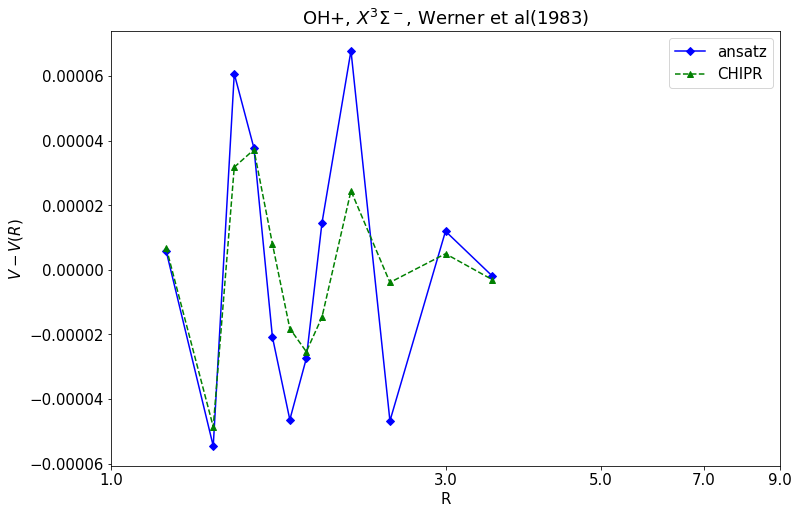

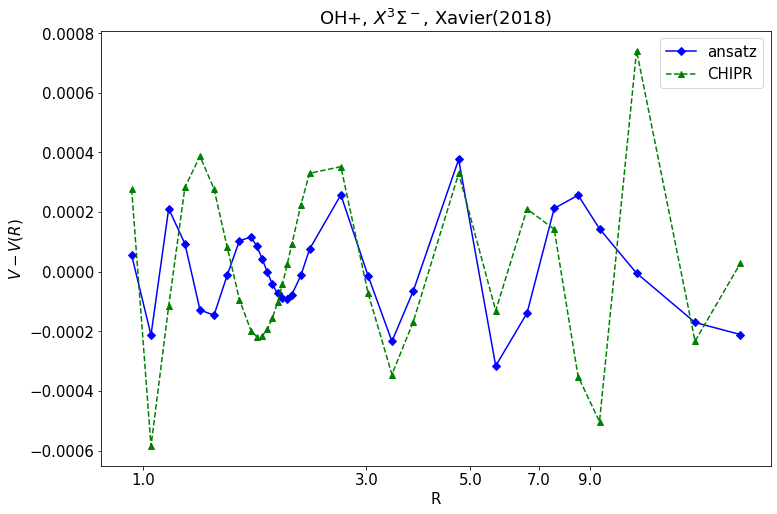

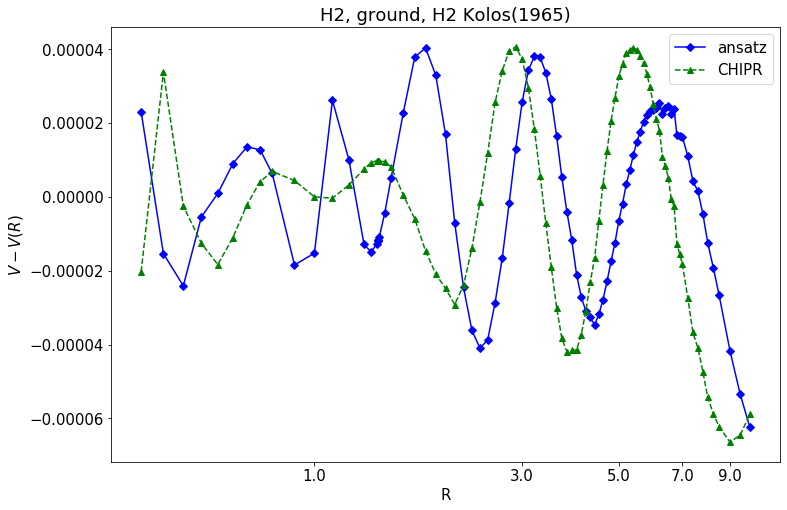

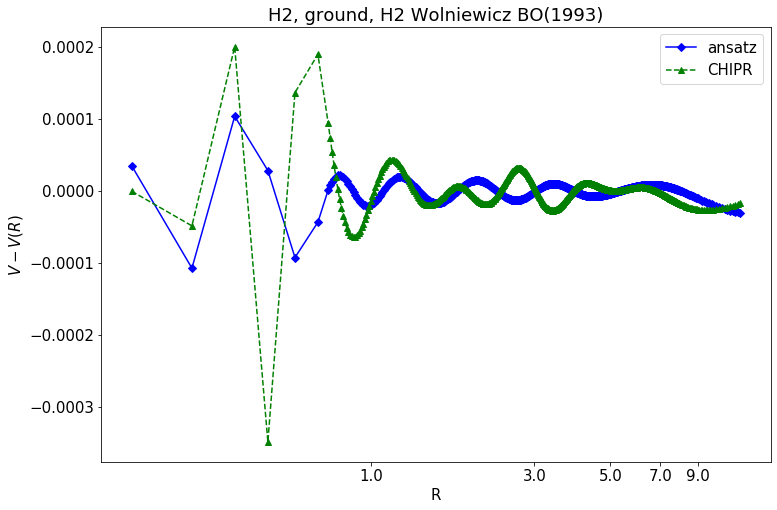

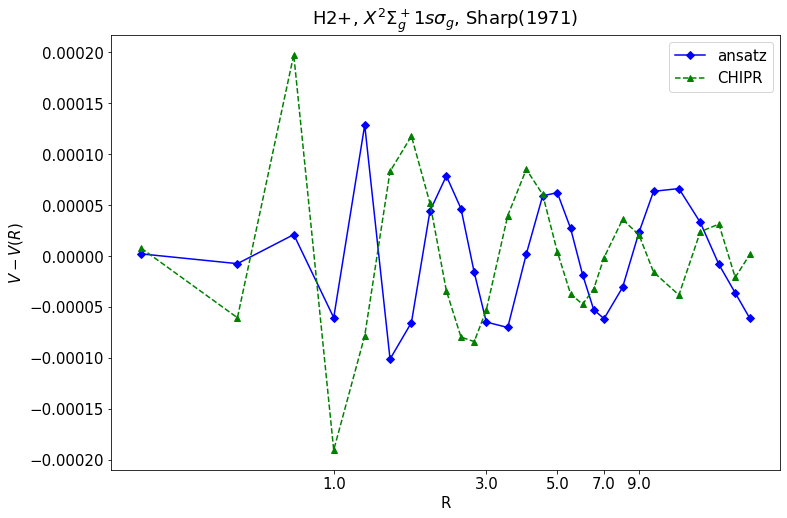

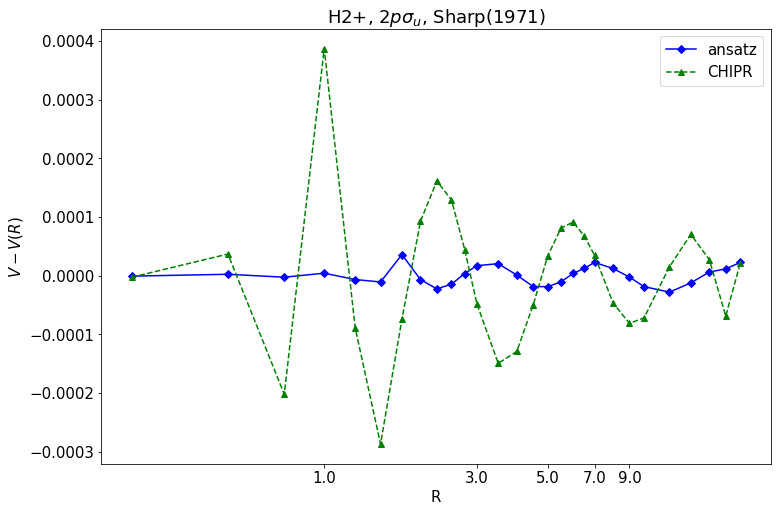

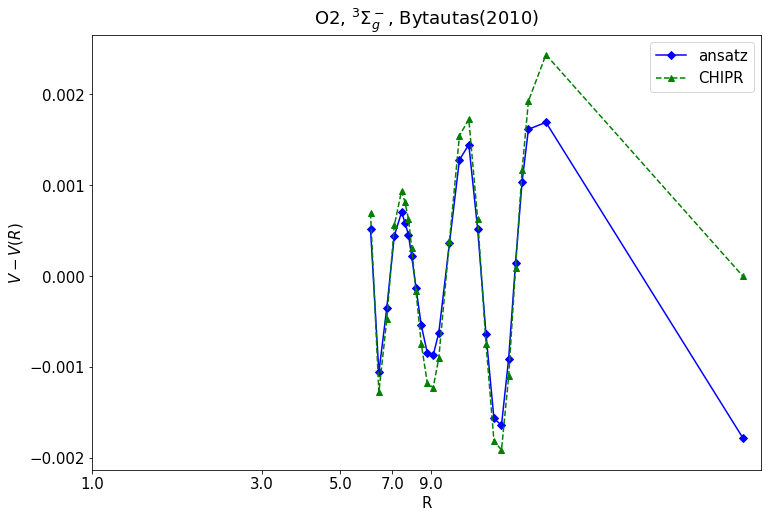

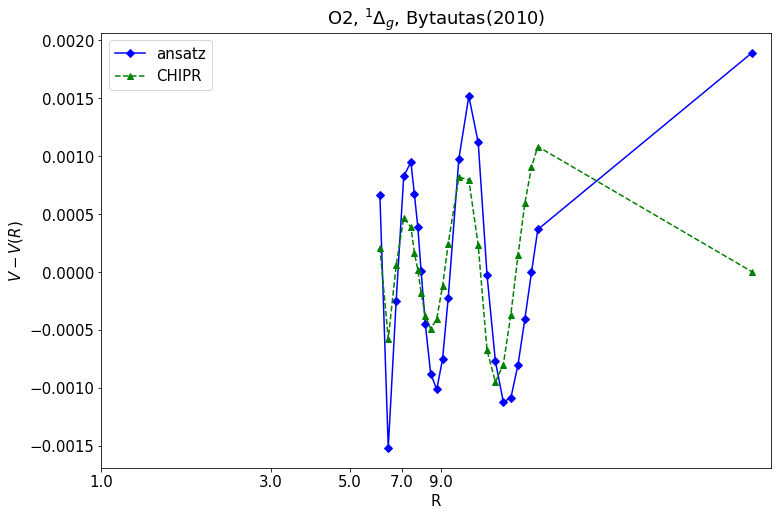

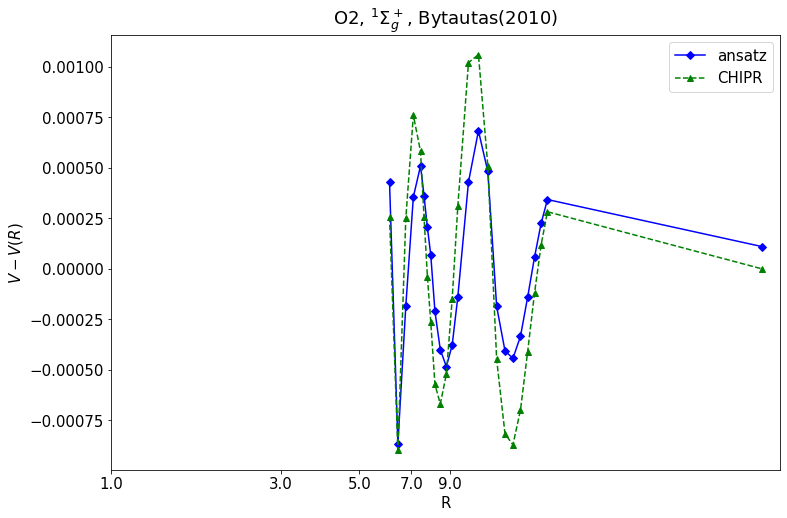

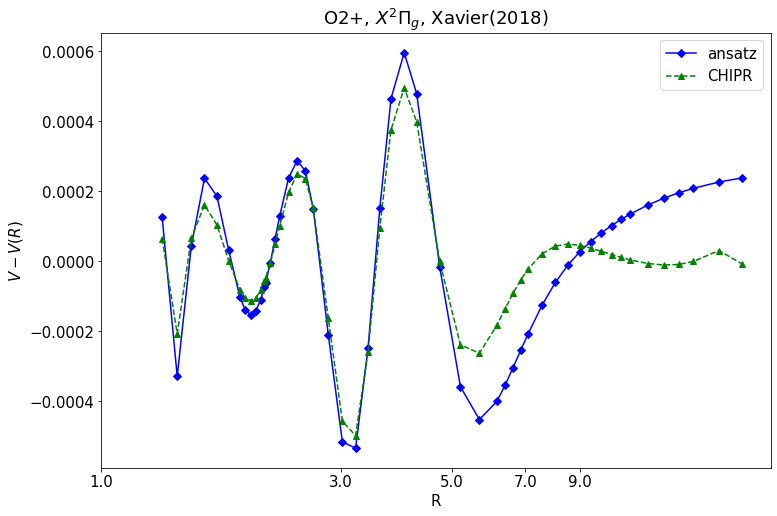

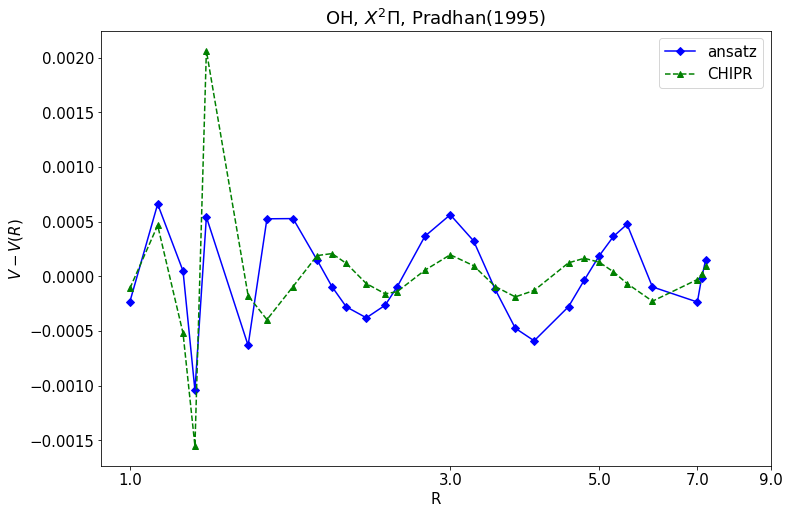

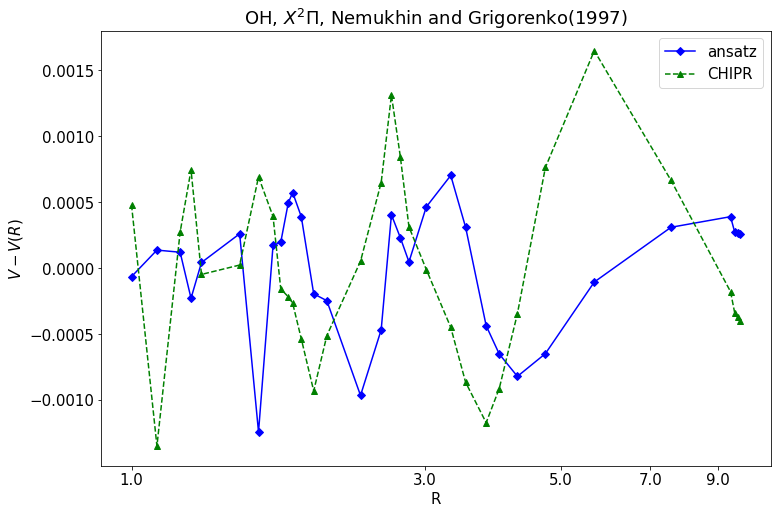

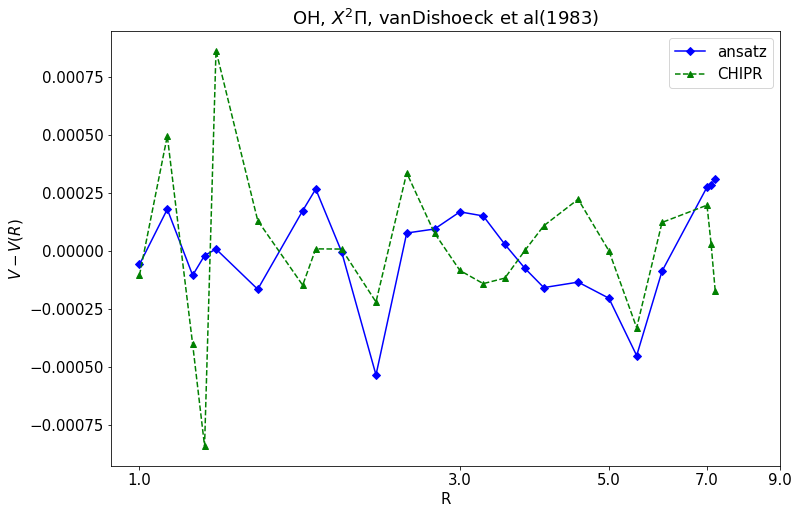

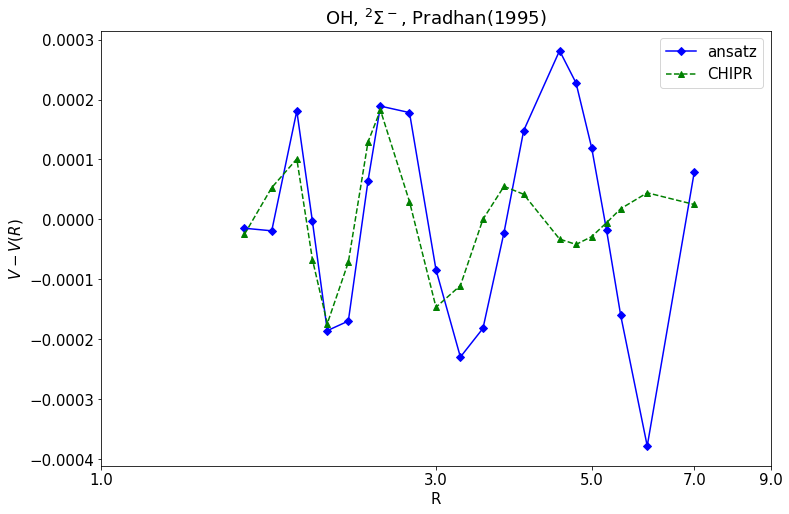

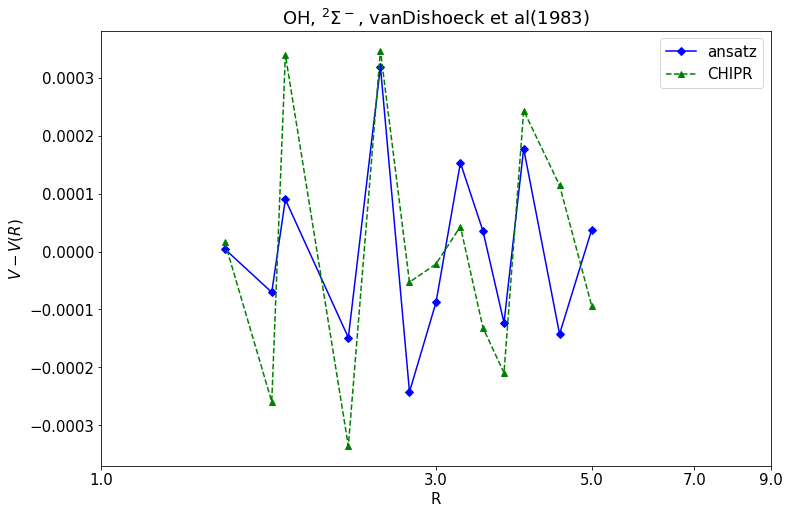

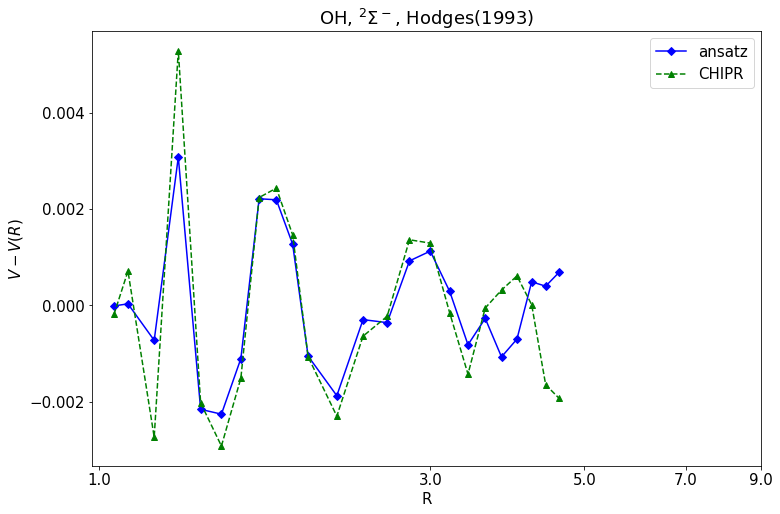

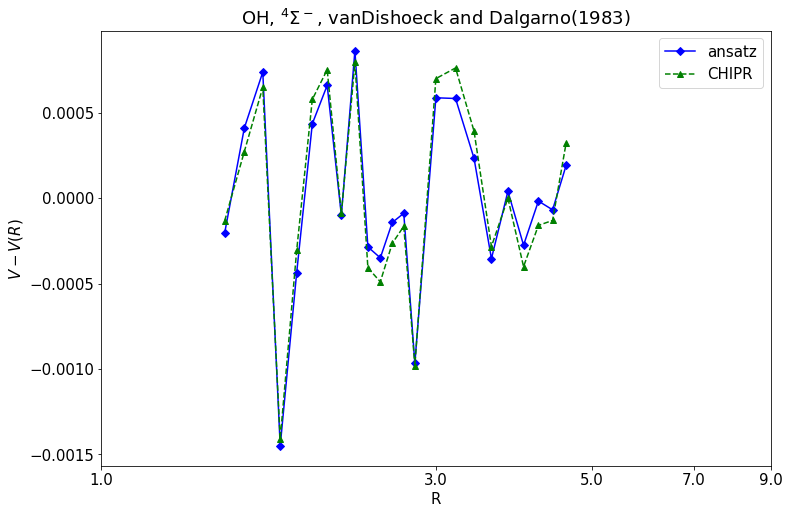

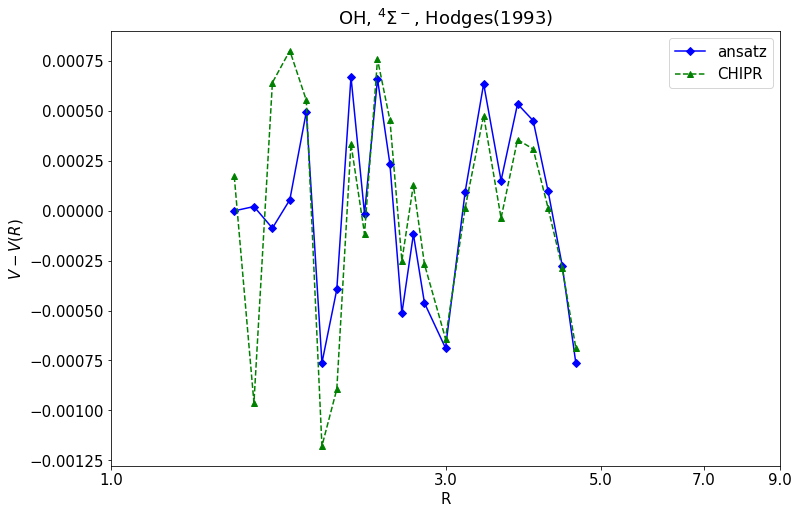

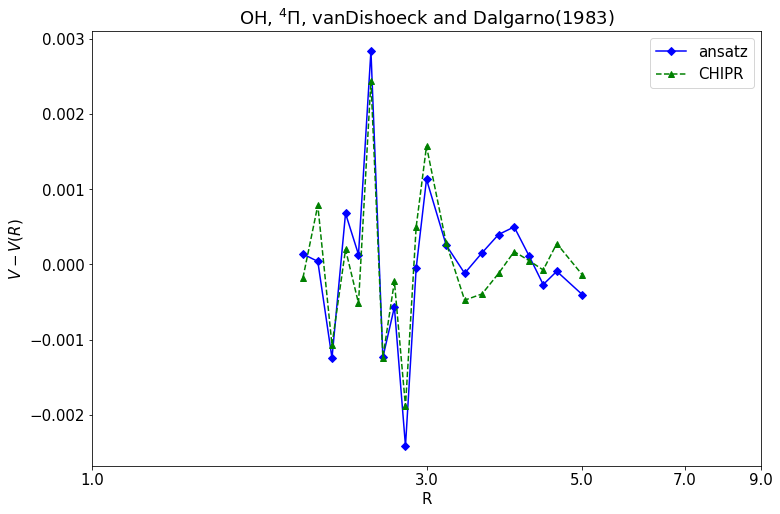

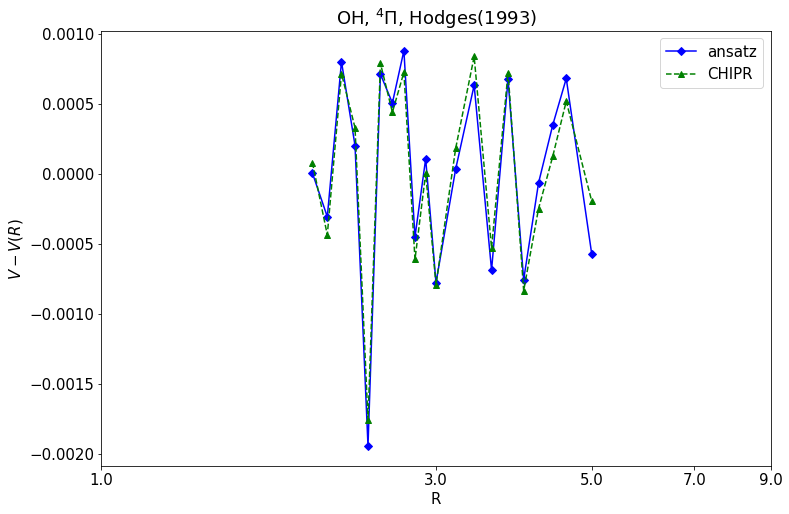

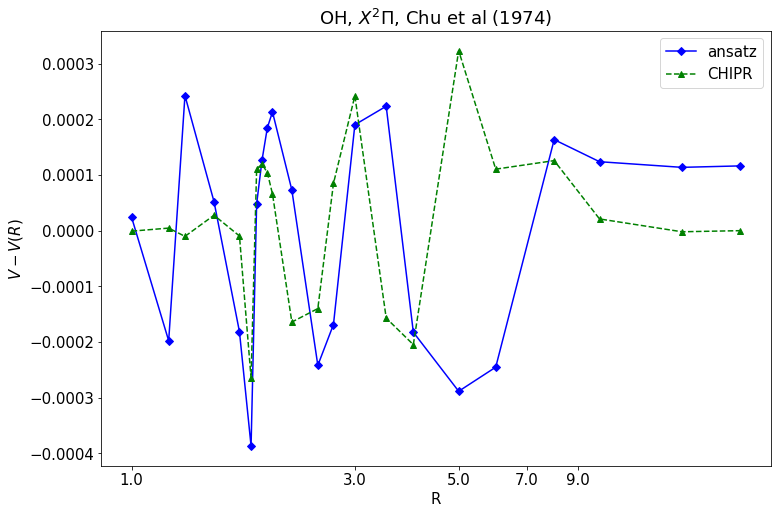

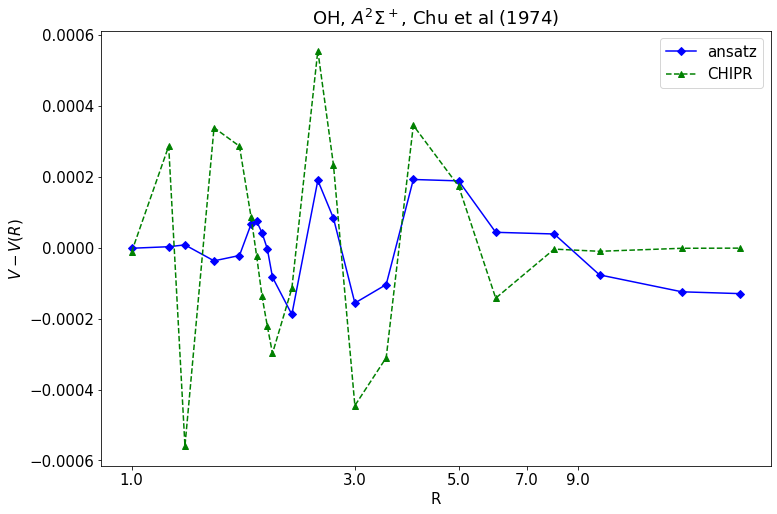

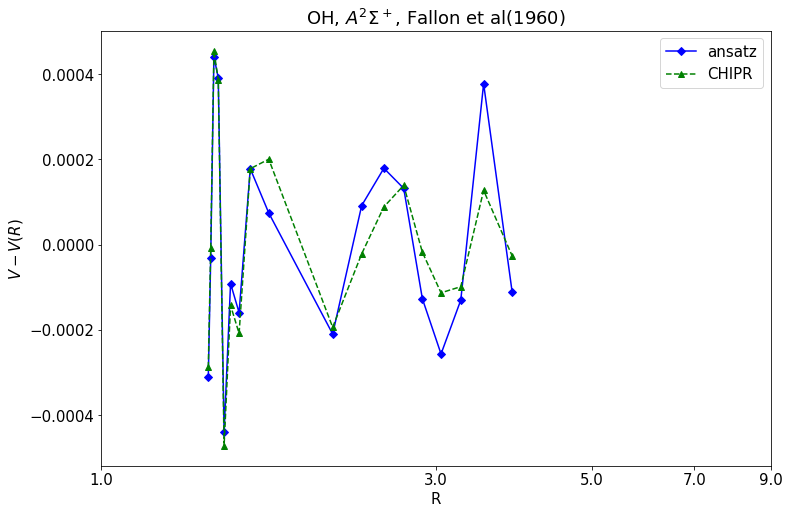

In [83]:
mols = ["OH+", "H2", "H2+", "O2", "O2+", "OH"]
#Zs = {"OH+":8, "H2":1, "H2+":1, "O2":64, "O2+":64, "OH":8}
M = int((data["num_params"][0]-1)/3)
m = int((2*M - 2)/3)
#get the C:
length = data.shape[0]
shapes = ["-bD","--g^"]
for mol in mols:
    for i in range(length):
        if data["mol"][i] == mol:
            #plot per mol per state per author:
            qidx = pdata.query_many_vars_indices([mol, data["state"][i], data["author"][i]], ["mol", "state", "author"], list_data)
            R = list_data[qidx[0]]["R"]; V = list_data[qidx[0]]["V"]; Z = data["Z"][i]

            #ansatz:
            C = data["ansatz_C"][i]
            V_pred = pmodel.f_diatomic_vdw(C, R, Z, M)
            err_a = V_pred - V

            #chipr:
            C = data["chipr_C"][i]
            V_pred = pmodel.f_diatomic_chipr_ohplus(C, R, Z, M, m)
            err_c = V_pred - V

            plt.subplots(figsize=(12, 8))
            plt.plot(np.log10(R), err_a, shapes[0])
            plt.plot(np.log10(R), err_c, shapes[1])
            ticks = np.linspace(1, 9, 5) #5 ticks between 1-9 Angstrom
            plt.xticks(np.log10(ticks), ticks)
            legends = ["ansatz", "CHIPR"]
            plt.xlabel("R")
            plt.ylabel("$V-V(R)$")
            plt.legend(legends)
            plt.title(str(data["mol"][i])+", "+str(data["state"][i])+", "+str(data["author"][i]) )

In [65]:
fname = "result/cross_val_each_state_121121_001441.pkl" #contains time eval
with open(fname, 'rb') as handle:
    data = pickle.load(handle)
print(data.keys())
print(data["mol"])
filter = ['ansatz_acc', 'chipr_acc'] #joined data filter
display = {k:data[k] for k in filter if k in data} #key filter
display = pd.DataFrame(display) #filter the data
display

dict_keys(['num_params', 'opt_restart', 'opt_power', 'opt_delta', 'mol', 'state', 'author', 'method', 'Z', 'ansatz_acc', 'ansatz_C', 'chipr_acc', 'chipr_C'])
['OH', 'OH', 'OH', 'OH', 'OH', 'OH', 'OH', 'OH', 'OH', 'OH', 'OH', 'OH', 'O2', 'O2', 'O2', 'H2', 'H2', 'OH+', 'H2+', 'H2+', 'OH+', 'O2+', 'OH']


,ansatz_acc,chipr_acc
0,0.000466,0.000450
1,0.000603,0.000720
2,0.000138,0.000294
3,0.000127,0.000070
4,0.000852,0.001243
5,0.002355,0.000812
6,0.000570,0.000569
7,0.000786,0.000534
8,0.001257,0.001346
9,0.001170,0.000980


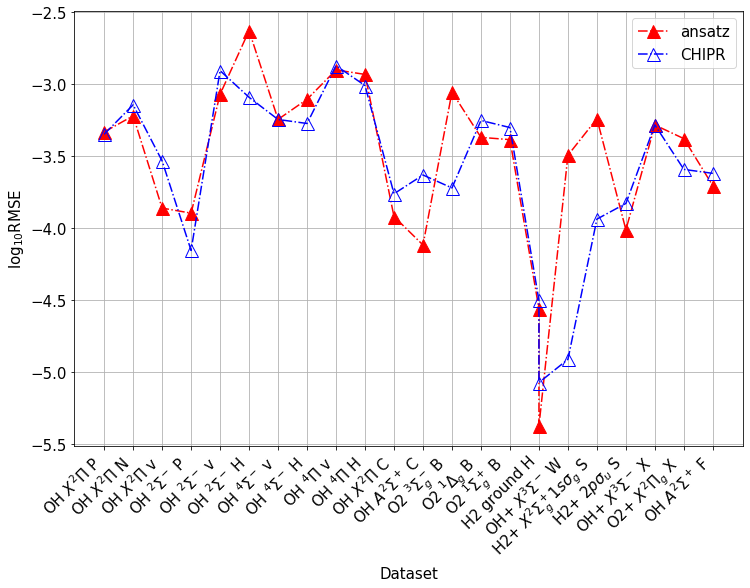

In [80]:
## plot of the table (finding which model is the best)
plt.rcParams.update({'font.size': 15})
#plt.subplots(figsize=(12, 8))
fig, ax = plt.subplots(figsize=(12, 8))

markersize = 13

x = [data["mol"][i]+" "+data["state"][i]+" "+data["author"][i][0] for i in range(len(data["mol"]))]
y = data["ansatz_acc"]
ax.plot(x, np.log10(y), '-.r^', markersize=markersize)
y = data["chipr_acc"]
ax.plot(x, np.log10(y), '-.b^', markersize=markersize, fillstyle="none")
plt.xticks(rotation=45, ha="right")

plt.xlabel("Dataset"); plt.ylabel("log$_{10}$RMSE")
plt.legend(["ansatz", "CHIPR"])
ax.grid()
plt.show()

### Visu 11-16-2021

dict_keys(['test_size', 'num_params', 'opt_restart', 'opt_power', 'opt_delta', 'ansatz_2_acc_train', 'ansatz_2_acc_test', 'ansatz_2_C', 'degree', 'simulation_time'])
[0.020474987703733107, 0.00023236846646669437, 0.0002325350014193759, 0.00023253500141938717, 0.00023253500141938663, 0.00023253500141940173, 0.00023253500141938481, 0.00023253500141939964, 0.00023253500141938915, 0.0002325350014193835, 0.00023253500141939403, 0.00023253500141940232, 0.00023253500141939417, 0.00023253500141940043, 0.0002325350014193918, 0.0002325350014193813, 0.0002325350014193961, 0.0002325350014193948, 0.00023253500141939064, 0.00023253500141939555]


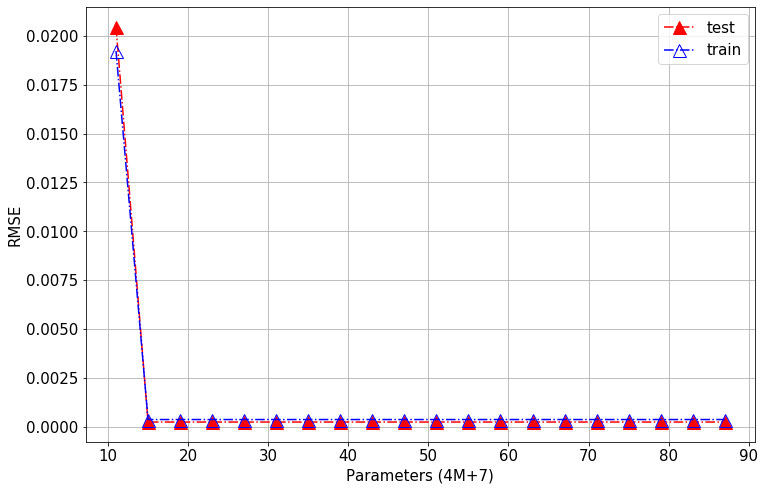

In [165]:
#fname = "result/spec_split_data_fit_OH+_151121_235158.pkl"
fname = "result/spec_split_data_fit_direct_OH+_161121_150347.pkl"
with open(fname, 'rb') as handle:
    data = pickle.load(handle)
print(data.keys())
print(data["ansatz_2_acc_test"])


## plot of the table (finding which model is the best)
plt.rcParams.update({'font.size': 15})
#plt.subplots(figsize=(12, 8))
fig, ax = plt.subplots(figsize=(12, 8))

markersize = 13

x = data["num_params"]
y = data["ansatz_2_acc_test"]
ax.plot(x, y, '-.r^', markersize=markersize)
y = data["ansatz_2_acc_train"]
ax.plot(x, y, '-.b^', markersize=markersize, fillstyle="none")
#plt.xticks(rotation=45, ha="right")


plt.xlabel("Parameters (4M+7)"); plt.ylabel("RMSE")
plt.legend(["test", "train"])
ax.grid()
plt.show()

dict_keys(['method', 'test_size', 'num_params', 'opt_restart', 'opt_power', 'opt_delta', 'ansatz_2_acc_train', 'ansatz_2_acc_test', 'ansatz_2_C', 'degree', 'simulation_time'])
dict_keys(['num_params', 'opt_restart', 'opt_power', 'opt_delta', 'chipr_t', 'chipr_acc_train', 'chipr_acc_test', 'chipr_C', 'ansatz_1_t', 'ansatz_1_acc_train', 'ansatz_1_acc_test', 'ansatz_1_C', 'degree', 'simulation_time'])
[11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63, 67, 71, 75, 79, 83, 87] [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88]


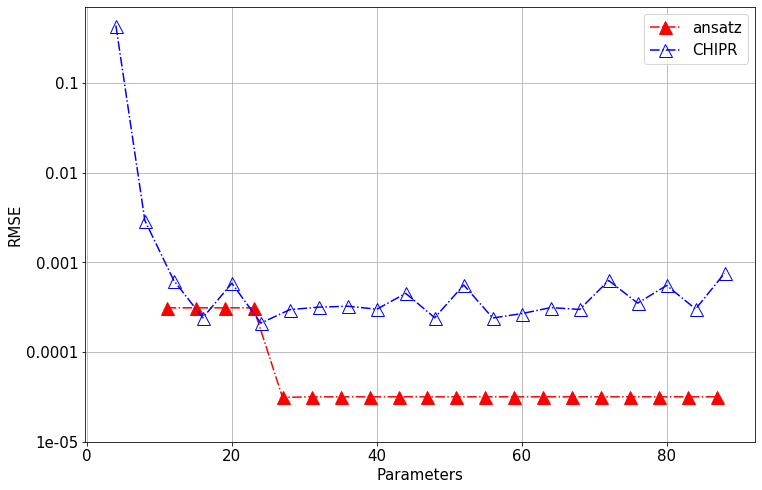

In [169]:
#fname = "result/spec_split_data_fit_OH+_161121_005103.pkl"
fname = "result/spec_split_data_fit_multirestart_OH+_161121_211534.pkl"
with open(fname, 'rb') as handle:
    data = pickle.load(handle)
print(data.keys())

#fname1 = "result/cross_val_performance_OH+_11112021.pkl"
fname1 = "result/split_data_fit_OH+171121_121942.pkl"
with open(fname1, 'rb') as handle:
    data1 = pickle.load(handle)
print(data1.keys())

print(data["num_params"], data1["num_params"])
## plot of the table (finding which model is the best)
plt.rcParams.update({'font.size': 15})
#plt.subplots(figsize=(12, 8))
fig, ax = plt.subplots(figsize=(12, 8))

markersize = 13

x = data["num_params"]
y = data["ansatz_2_acc_test"]
ax.plot(x, np.log10(y), '-.r^', markersize=markersize)
x = data1["num_params"]
y = data1["chipr_acc_test"]
ax.plot(x, np.log10(y), '-.b^', markersize=markersize, fillstyle="none")
interval = [1e-1,1e-2, 1e-3, 1e-4, 1e-5]
plt.yticks(np.log10(interval), interval)
#plt.xticks(rotation=45, ha="right")

plt.xlabel("Parameters"); plt.ylabel("RMSE")
plt.legend(["ansatz", "CHIPR"])
ax.grid()
plt.show()

In [41]:
#see residual here, using prev coeffs:
fname = "result/cross_val_performance_OH+_11112021.pkl" #contains time eval
with open(fname, 'rb') as handle:
    data = pickle.load(handle)
print(data["simulation_time"])

15895.41940832138


### Conical Intersection

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


<IPython.core.display.Javascript object>


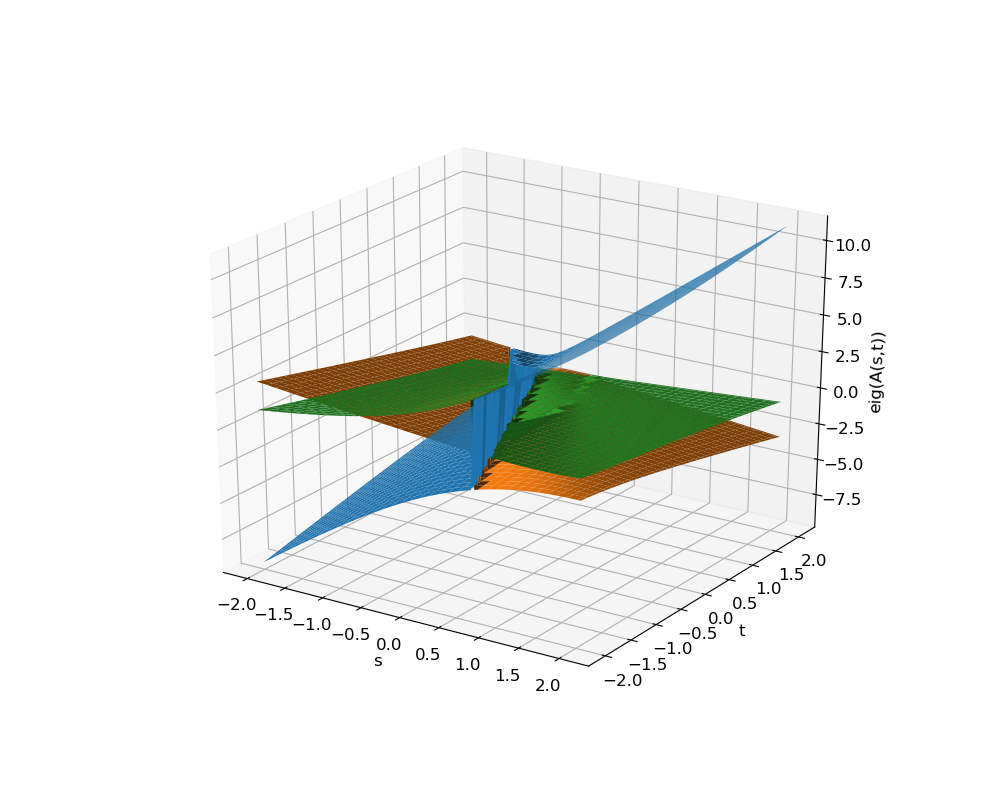

Text(0.5, 0, 'eig(A(s,t))')

In [171]:
%matplotlib notebook

from numpy import linalg as LA
from mpl_toolkits.mplot3d import Axes3D
# (s,t) = (2,−1) conical intersection
t = s = np.linspace(-2.01,2.05,101)
#high definition 
sv, tv = np.meshgrid(s, t)
def con_3_sheet(s, t): #the z coordinate, which is the eigenvalue, three sheeted surface
    A = lambda s,t: np.array([
            [t, 2*t + s, t+1],
            [2*t + s, 2*t, t+1],
            [t+ 1, t+1, t+1-s]
        ])
    w, _ = LA.eig(A(s, t)) 
    return w

#generate z:
z = np.zeros((len(s)*len(t),3))
print(z)
i = 0
for si in s:
    for ti in t:
        z[i] = con_3_sheet(si, ti)
        i+=1

plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(sv, tv, z.T[0].reshape(sv.shape))
ax.plot_surface(sv, tv, z.T[1].reshape(sv.shape))
ax.plot_surface(sv, tv, z.T[2].reshape(sv.shape))

ax.set_xlabel('s')
ax.set_ylabel('t')
ax.set_zlabel('eig(A(s,t))')

[0.  0.5 1. ] [0. 1.]
[[0.  0.5 1. ]
 [0.  0.5 1. ]]
[[0. 0. 0.]
 [1. 1. 1.]]
[[0.  0.5 1. ]
 [1.  1.5 2. ]]


Text(0.5, 0, 'Z Label')

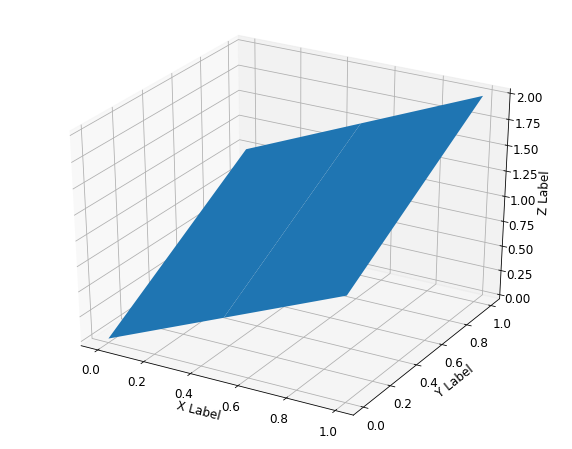

In [114]:
from mpl_toolkits.mplot3d import Axes3D

x = np.linspace(0, 1, 3)
y = np.linspace(0, 1, 2)
print(x, y)
xv, yv = np.meshgrid(x, y)
print(xv)
print(yv)
z = lambda x,y: x + y
print(z(xv, yv))

plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xv, yv, z(xv, yv))

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')